In [1]:
import torch
from torch.utils.data import DataLoader
from state_quantization.dataset import load_dataset
from state_quantization.dataset import DynamicsModelDataset
from state_quantization.quantization_models import ForcastingDiscFinalState, ForcastingDiscFinalStateConst
from state_quantization.train import train_model, test_step
from state_quantization.eval import eval_model, compare_models
from torch.optim.lr_scheduler import MultiStepLR
from state_quantization.trainer import NNTrainer

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Using Device: {device}")
torch.backends.cudnn.benchmark = True


Using Device: cuda:0


## Load Dataset

In [3]:
dataset_input_key = 'merged_input'
dataset_output_key = 'merged_output'
dataset_file_path = 'tmp/ib-out/ib-samples-la.npy'
normalized_data_params_save_path = 'tmp/transformer/NormalizeInputConfigs.pkl'
dataset_device = 'cpu'
y_indexes = [4, 6]

train_dataset, val_dataset = load_dataset(file_path=dataset_file_path, input_key=dataset_input_key,
                                          output_key=dataset_output_key, dataset_class=DynamicsModelDataset,
                                          normalize=True, device=dataset_device, y_clip_range=y_indexes,
                                          normalized_input_data_params_save_path=normalized_data_params_save_path)

batch_size = 8000
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': True,
          'pin_memory': not train_dataset.x.is_cuda}
print(params)
train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)
train_dataset.y[0]

Clipping y
torch.Size([672000, 39, 6])
torch.Size([672000, 10, 2])
torch.Size([288000, 39, 6])
torch.Size([288000, 10, 2])
{'batch_size': 8000, 'shuffle': True, 'num_workers': 0, 'drop_last': True, 'pin_memory': True}


tensor([[-1.0641, -0.1080],
        [-1.0641, -0.0172],
        [-1.0641,  0.0558],
        [-0.9367,  0.2030],
        [-1.0641,  0.4203],
        [-1.0641,  0.6223],
        [-1.0641,  0.9203],
        [-1.0641,  1.1451],
        [-1.0641,  1.1718],
        [-0.9900,  1.0436]])

## Define model

In [4]:
model_dict_path = 'tmp/state_quantization/model_final_h_dict'


num_of_features = train_dataset.get_features_size()
seq_len = train_dataset.get_seq_len()
hidden_size = 20
model_path = f'tmp/state_quantization/model_final_h{hidden_size}bits2'
untrained_model_path = f'tmp/state_quantization/untrained_model_final_h{hidden_size}bits'
out_size = train_dataset.get_output_feature_size()
print(f'Out Size:{out_size}')
look_ahead = train_dataset.get_look_ahead_size()
n_layers = 1
dropout_p = 0.1
print(look_ahead)
model = ForcastingDiscFinalState(features=num_of_features, hidden_size=hidden_size, out_size=out_size, seq_len=seq_len,
                               n_layers=n_layers, dropout=dropout_p,
                               look_ahead=look_ahead).to(device=device)
torch.save(model, untrained_model_path)
load_to_gpu = model.is_cuda() and not train_dataset.x.is_cuda
print(load_to_gpu)

Out Size:2
9
LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)
True


## Train Model

In [5]:


gamma = 0.1
lr_milestones = [30, 60]
lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = MultiStepLR(optimizer, milestones=lr_milestones, gamma=gamma)
trainer = NNTrainer(model=model,train_loader=train_loader, test_loader=val_loader,load_to_gpu=load_to_gpu,optimizer=optimizer, lr_scheduler=lr_scheduler, train_loss_graph_tags=['Forecasting/train/loss'], eval_loss_graph_tags=['Forecasting/Eval/loss', 'Model/Eval/loss'])

In [6]:
trainer.train(n_epochs=50)
# train_model(model=model, train_loader=train_loader, test_loader=val_loader, n_epochs=100, learning_rate=1e-3,
#             load_to_gpu=load_to_gpu, gamma=0.1, lr_milestones=[30, 60])

Untrained test
--------
--------------------------------------
Model Test loss: 1.0324756056070328
--------------------------------------
--------------------------------------
Epoch 1
---------
--------------------------------------
Model Train loss: 0.774125854174296
--------------------------------------
Model Test loss: 0.43733274853891796
--------------------------------------
lr: [0.001]
Epoch time: epoch_time = 9.040s
--------------------------------------
--------------------------------------
Epoch 2
---------
--------------------------------------
Model Train loss: 0.3323417761850925
--------------------------------------
Model Test loss: 0.2005420062277052
--------------------------------------
lr: [0.001]
Epoch time: epoch_time = 9.048s
--------------------------------------
--------------------------------------
Epoch 3
---------
--------------------------------------
Model Train loss: 0.17337416449473017
--------------------------------------
Model Test loss: 0.1130131671

## Save Model

In [7]:

torch.save(model.state_dict(), model_dict_path)
torch.save(model, model_path)
torch.cuda.empty_cache()
del model

## Load Model for evaluation

In [8]:

model_classes = [ForcastingDiscFinalState, ForcastingDiscFinalStateConst]
models = []
for model_class in model_classes:
    models.append(model_class(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
                              seq_len=seq_len, n_layers=n_layers, dropout=dropout_p,
                              look_ahead=look_ahead).to(device))
    models[-1].load_state_dict(torch.load(model_dict_path))

LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)
LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)


In [9]:
for la_model in models:
    print(la_model.__class__.__name__)
    test_step(model=la_model, data_loader=val_loader, loss_function=torch.nn.MSELoss(), load_to_gpu=load_to_gpu)

ForcastingDiscFinalState
Test loss: 0.054542897165649466
ForcastingDiscFinalStateConst
Test loss: 0.1463386925558249


LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)
LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)


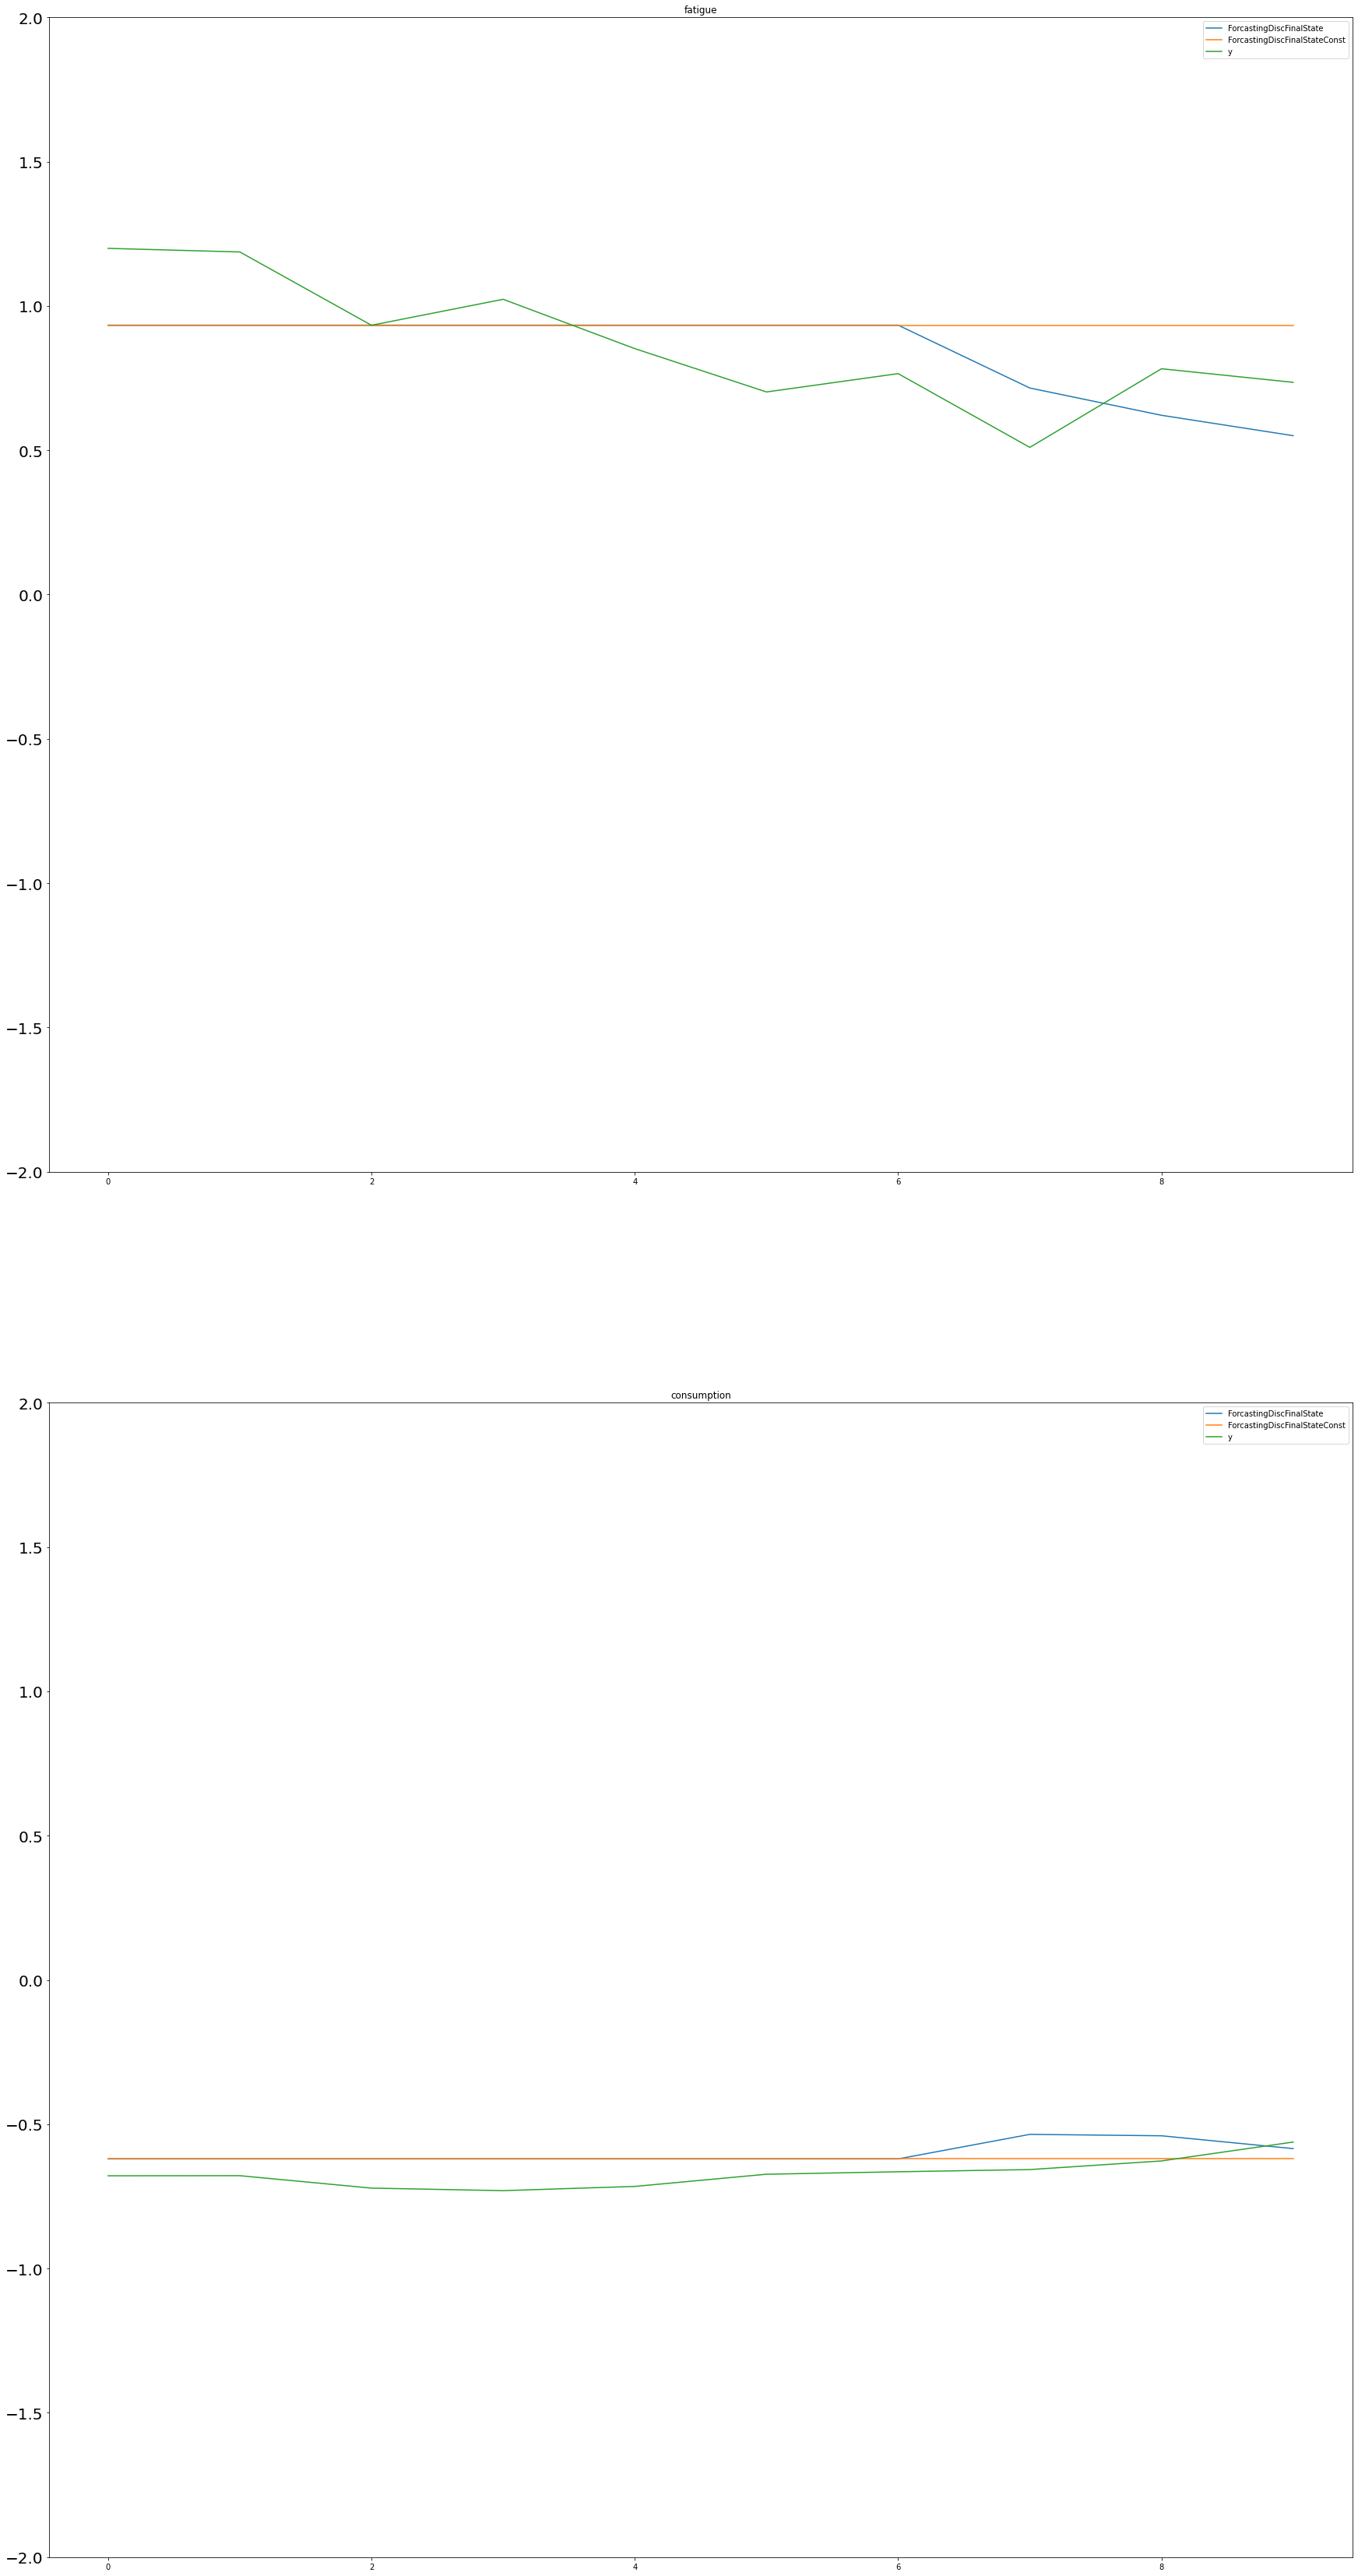

In [10]:
#value_keys = ['setpoint', 'velocity', 'gain', 'shift', 'fatigue', 'consumption']
value_keys = ['fatigue', 'consumption']

models = []
for model_class in model_classes:
    models.append(model_class(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
                              seq_len=seq_len, n_layers=n_layers, dropout=dropout_p,
                              look_ahead=look_ahead).to(dataset_device))
    models[-1].load_state_dict(torch.load(model_dict_path))

compare_models(models, x=val_dataset.x[78], y=val_dataset.y[78], value_keys=value_keys)